# **Data Loading & Pre-Processing**

In [ ]:
# Relevant Imports for both Sections
import os
import pandas as pd
import numpy as np
import joblib
import tensorflow as tf
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, precision_score, accuracy_score
from tensorflow import keras
from sklearn.metrics import confusion_matrix, recall_score, f1_score
from sklearn import svm
from PIL import Image
from tqdm import tqdm

In [16]:
# # Import the dataset
# import kagglehub

# # Download latest version
# path = kagglehub.dataset_download("flo2607/traffic-signs-classification")

# print("Path to dataset files:", path)

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

# Download the dataset
path = api.dataset_download_files("flo2607/traffic-signs-classification", path="datasets", unzip=True)
print("Path to dataset files:", path)

Path to dataset files:


In [ ]:
# Store the labels
dataset_folder = os.path.join(os.getcwd(), "datasets")
labels_df = pd.read_csv(os.path.join(dataset_folder, "labels.csv"))
print(labels_df.head())

   ClassId                  Name
0        0  Speed limit (20km/h)
1        1  Speed limit (30km/h)
2        2  Speed limit (50km/h)
3        3  Speed limit (60km/h)
4        4  Speed limit (70km/h)


In [ ]:
# Get all the images from the subfolders and store them with the path and class ID
image_dir = os.path.join(dataset_folder, "myData")

data = []
for class_id in os.listdir(image_dir):
    class_path = os.path.join(image_dir, class_id)
    if os.path.isdir(class_path):
        for img_file in os.listdir(class_path):
            data.append({
                "filepath": os.path.join(class_path, img_file),
                "class_id": int(class_id)
            })

images_df = pd.DataFrame(data)
print(images_df.head())
print("Total images:", len(images_df))


                                            filepath  class_id
0  c:\Users\karti\Documents\Repositories\COMPSYS ...         0
1  c:\Users\karti\Documents\Repositories\COMPSYS ...         0
2  c:\Users\karti\Documents\Repositories\COMPSYS ...         0
3  c:\Users\karti\Documents\Repositories\COMPSYS ...         0
4  c:\Users\karti\Documents\Repositories\COMPSYS ...         0
Total images: 73139


In [ ]:
# Combine labels with images
final_df = images_df.merge(labels_df, left_on="class_id", right_on="ClassId")
final_df = final_df.drop(columns=["ClassId"])  # avoid duplicate column

print(final_df.head())

                                            filepath  class_id  \
0  c:\Users\karti\Documents\Repositories\COMPSYS ...         0   
1  c:\Users\karti\Documents\Repositories\COMPSYS ...         0   
2  c:\Users\karti\Documents\Repositories\COMPSYS ...         0   
3  c:\Users\karti\Documents\Repositories\COMPSYS ...         0   
4  c:\Users\karti\Documents\Repositories\COMPSYS ...         0   

                   Name  
0  Speed limit (20km/h)  
1  Speed limit (20km/h)  
2  Speed limit (20km/h)  
3  Speed limit (20km/h)  
4  Speed limit (20km/h)  


In [14]:
# Pre-process Images to ensure they're all the same size and format
# Target size
IMG_SIZE = (32, 32)

X = []
y = []

for idx, row in tqdm(final_df.iterrows(), total=len(final_df)):
    # Open image
    img = Image.open(row["filepath"])

    # Resize
    img = img.resize(IMG_SIZE, Image.LANCZOS) #Image.LANCZOS is a high-quality downsampling filter

    # Convert to array
    img_array = np.array(img)

    # Normalize (0–255 → 0–1)
    img_array = img_array / 255.0

    # Store data
    X.append(img_array)
    y.append(row["class_id"])

# Convert lists to numpy arrays
X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)
print("y shape:", y.shape)


100%|██████████| 73139/73139 [23:12<00:00, 52.51it/s] 


X shape: (73139, 32, 32, 3)
y shape: (73139,)


In [21]:
print("CPU cores available:", os.cpu_count())

CPU cores available: 12


In [19]:
# Save the processed images so you don't have to keep re-processing them
np.save("X_processed.npy", X)
np.save("y_labels.npy", y)

In [71]:
# Load processed imahes
X = np.load("X_processed.npy")
y = np.load("y_labels.npy")

In [72]:
# Split X into training and testing split of 80-20
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Split Training into training and validation split of 80-20 for MLP
X_train1, X_val, y_train1, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0, stratify=y_train)

# **MLP Section:**

In [73]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(43)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                 patience=3, min_lr=1e-6, verbose=1)

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(X_train1, y_train1, validation_data=(X_val, y_val),epochs=30, callbacks=[lr_scheduler, early_stop])
# checking the model's performance using model.evaluate
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)

print('\nTest accuracy:', test_acc)

c:\Users\karti\anaconda3\envs\cs302\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.


Epoch 1/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 24s 15ms/step - accuracy: 0.3555 - loss: 2.5931 - val_accuracy: 0.7546 - val_loss: 0.9817 - learning_rate: 5.0000e-04
Epoch 2/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 23s 16ms/step - accuracy: 0.7792 - loss: 0.8713 - val_accuracy: 0.8295 - val_loss: 0.6680 - learning_rate: 5.0000e-04
Epoch 3/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 23s 15ms/step - accuracy: 0.8470 - loss: 0.6132 - val_accuracy: 0.8444 - val_loss: 0.5999 - learning_rate: 5.0000e-04
Epoch 4/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 25s 17ms/step - accuracy: 0.8791 - loss: 0.4919 - val_accuracy: 0.8968 - val_loss: 0.4390 - learning_rate: 5.0000e-04
Epoch 5/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.8981 - loss: 0.4079 - val_accuracy: 0.8936 - val_loss: 0.4134 - learning_rate: 5.0000e-04
Epoch 6/30
1463/1463 ━━━━━━━━━━━━━━━━━━━━ 29s 20ms/step - accuracy: 0.9068 - loss: 0.3600 - val_accuracy: 0.9094 - val_loss: 0.3526 - learning_rate: 5.0000e-04
Epoch 7/30
1463/1463 ━━━━━━━━━━━━━━━━━━━

*   Training accuracy: 97–98%
*   Validation accuracy: steadily rises and reaches ~98% by epoch 30
*   Validation loss: decreases consistently toward the end (0.1018)
*   Test accuracy: 97.96%

In [36]:
# Save model to avoid having to retrain
model.save("mlp_model.keras")

In [63]:
# To load model if required
loaded_model = keras.models.load_model("mlp_model.keras")

458/458 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step
Classification Report:

              precision    recall  f1-score   support

           0     0.9878    0.9878    0.9878        82
           1     0.9449    0.9656    0.9551       959
           2     0.9607    0.8644    0.9100       509
           3     0.9097    0.9601    0.9342       577
           4     0.9435    0.9869    0.9647       761
           5     0.9646    0.9237    0.9437       708
           6     0.9876    0.9876    0.9876       161
           7     0.9898    0.8965    0.9408       541
           8     0.9393    0.9850    0.9616       534
           9     0.9723    0.9877    0.9799       569
          10     1.0000    0.9702    0.9849       739
          11     1.0000    0.9456    0.9721       515
          12     0.9884    0.9758    0.9820       784
          13     0.9792    0.9926    0.9859       808
          14     0.9888    1.0000    0.9944       265
          15     0.9390    0.9901    0.9639       202
          16    

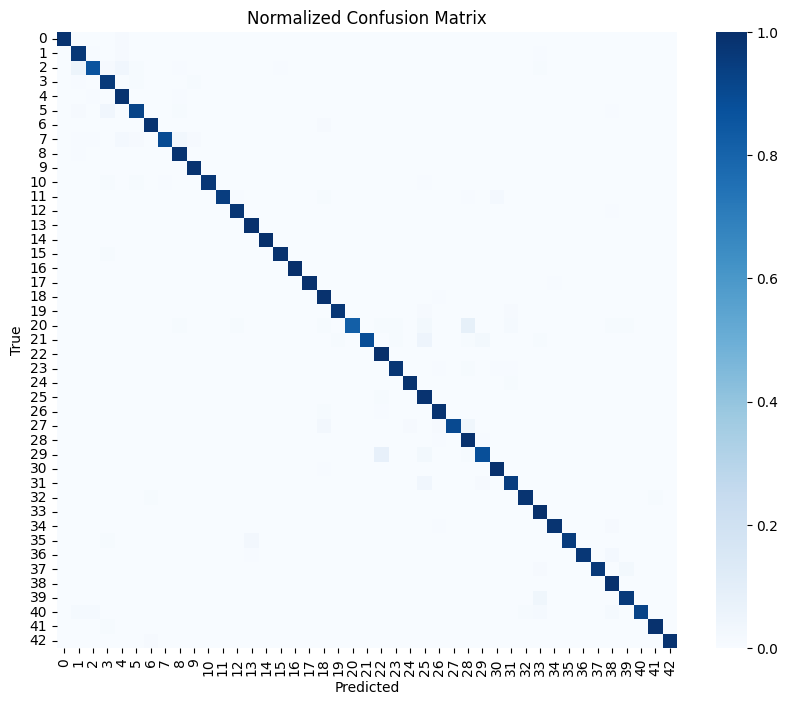

Precision: 0.966939809851563
Recall: 0.9660240634399782
F1 Score: 0.965867079011135


In [66]:
# Convert the MLP probabiltiies outputs into predictions of the specific label and then evaluate the models performance
# Get raw predictions (probabilities/logits)
y_pred_prob = loaded_model.predict(X_test)

# Convert to class labels (choose the class with max probability)
y_pred = y_pred_prob.argmax(axis=1)

# confusion matrix
print("Classification Report:\n")
print(classification_report(y_test, y_pred, digits=4))

print("Confusion Matrix:\n")
cm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Precision ---
# Precision answers: "Of all the samples predicted as positive, how many are actually positive?"
# Formula: Precision = TP / (TP + FP)
precision = precision_score(y_test, y_pred, average='weighted') # use 'weighted' for multi-class

# --- Recall ---
# Recall answers: "Of all the actual positive samples, how many did we correctly identify?"
# Formula: Recall = TP / (TP + FN)
recall = recall_score(y_test, y_pred, average='weighted')

# --- F1 Score ---
# The F1 score is the harmonic mean of Precision and Recall.
# It balances the trade-off between the two (useful when classes are imbalanced).
# Formula: F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1 = f1_score(y_test, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# **SVM Section:**

In [67]:
# Flattenn the Images for SVM
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

# The labels stay the same
y_train_flat = y_train
y_test_flat = y_test

print(X_train_flat.shape, X_test_flat.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)


(58511, 3072) (14628, 3072)


In [ ]:
# Apply PCA
pca = PCA(n_components=0.98)  # Keep 98% of variance
X_train_pca = pca.fit_transform(X_train_scaled)  # Fit on train
X_test_pca = pca.transform(X_test_scaled)        # Transform test

print("After PCA:", X_train_pca.shape, X_test_pca.shape)

After PCA: (46808, 241) (14628, 241)


In [ ]:
# Function for finding best SVM model parameters
def run_gridsearch(X, y, param_grid, filename):
    svc = svm.SVC(probability)
    grid = GridSearchCV(svc, param_grid, cv=3, n_jobs=-1, verbose=3, error_score=np.nan) # might have to change this to 3

    print(f"Starting grid search with params: {param_grid}")
    grid.fit(X, y)

    # Save checkpoint
    joblib.dump(grid, filename)
    print(f"Saved checkpoint: {filename}")
    return grid

In [26]:
#Split the grids into batches
param_grid1 = {'C': [0.1, 1], 'gamma': [0.0001, 0.001], 'kernel': ['linear']}
param_grid2 = {'C': [1, 10], 'gamma': [0.001, 0.1], 'kernel': ['rbf']}
param_grid3 = {'C': [0.1, 1], 'gamma': [0.0001, 0.001], 'kernel': ['poly']}

In [ ]:
# Run each batch and save them to different files
grid1 = run_gridsearch(X_train_pca, y_train_flat, param_grid1, "grid1.pkl")

Starting grid search with params: {'C': [0.1, 1], 'gamma': [0.0001, 0.001], 'kernel': ['linear']}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Saved checkpoint: grid1.pkl


In [ ]:
grid2 = run_gridsearch(X_train_pca, y_train_flat, param_grid2, "grid2.pkl")

Starting grid search with params: {'C': [1, 10], 'gamma': [0.001, 0.1], 'kernel': ['rbf']}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Saved checkpoint: grid2.pkl


In [ ]:
grid3 = run_gridsearch(X_train_pca, y_train_flat, param_grid3, "grid3.pkl")

Starting grid search with params: {'C': [0.1, 1], 'gamma': [0.0001, 0.001], 'kernel': ['poly']}
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Saved checkpoint: grid3.pkl


In [30]:
grids = [joblib.load("grid1.pkl"), joblib.load("grid2.pkl"), joblib.load("grid3.pkl")]

# Concatenate results
all_results = pd.concat([pd.DataFrame(g.cv_results_) for g in grids], ignore_index=True)

# Find best params overall
best_idx = all_results['mean_test_score'].idxmax()
best_params = all_results.loc[best_idx, 'params']
best_score = all_results.loc[best_idx, 'mean_test_score']

print("Best params:", best_params)
print("Best CV score:", best_score)

Best params: {'C': 10, 'gamma': 0.001, 'kernel': 'rbf'}
Best CV score: 0.9706247155726921


In [44]:
# Train final model with best params
model = svm.SVC(**best_params, probability=True)
model.fit(X_train_pca, y_train_flat)

SVC(C=10, gamma=0.001, probability=True)

In [74]:
# Save model
joblib.dump(model, "svc_model.pkl")

['svc_model.pkl']

In [69]:
# Load model later
loaded_model = joblib.load("svc_model.pkl")

# Test the model on the test set
y_pred=model.predict(X_test_pca)
print(f"The models is {accuracy_score(y_test_flat, y_pred)*100}% accurate")

The models is 98.42767295597484% accurate


Classification Report:

              precision    recall  f1-score   support

           0     1.0000    0.9878    0.9939        82
           1     0.9626    0.9937    0.9779       959
           2     0.9762    0.9666    0.9714       509
           3     0.9535    0.9601    0.9568       577
           4     0.9690    0.9869    0.9779       761
           5     0.9829    0.9760    0.9794       708
           6     1.0000    1.0000    1.0000       161
           7     0.9962    0.9667    0.9812       541
           8     0.9888    0.9944    0.9916       534
           9     0.9947    0.9895    0.9921       569
          10     0.9892    0.9946    0.9919       739
          11     0.9733    0.9922    0.9827       515
          12     0.9736    0.9860    0.9797       784
          13     0.9805    0.9975    0.9890       808
          14     1.0000    0.9925    0.9962       265
          15     1.0000    0.9851    0.9925       202
          16     1.0000    1.0000    1.0000       164
   

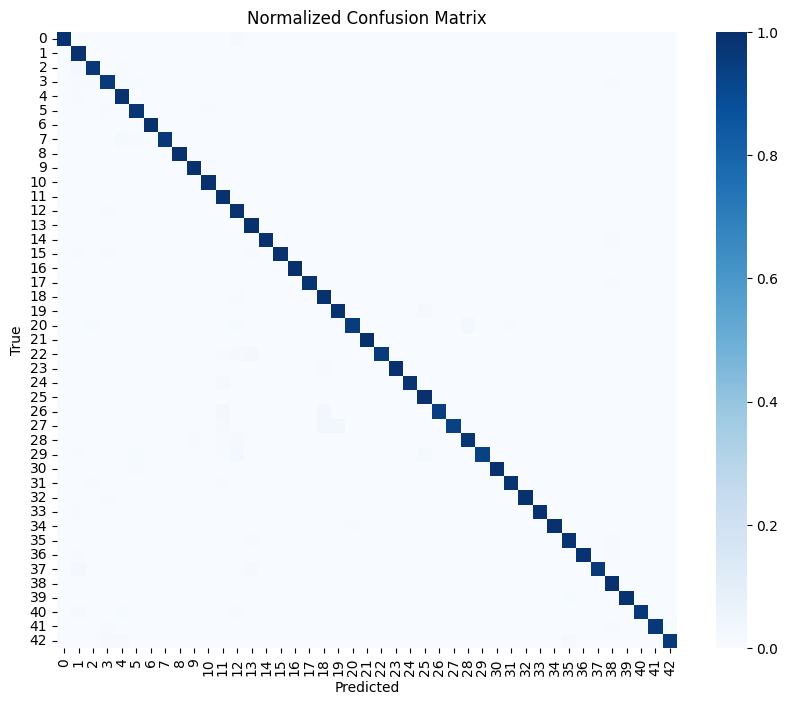

Precision: 0.9844557755585658
Recall: 0.9842767295597484
F1 Score: 0.9842716924210478


In [75]:
# confusion matrix
print("Classification Report:\n")
print(classification_report(y_test_flat, y_pred, digits=4))

print("Confusion Matrix:\n")
cm = confusion_matrix(y_test_flat, y_pred, normalize='true')
plt.figure(figsize=(10,8))
sns.heatmap(cm, cmap='Blues', annot=False)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# --- Precision ---
# Precision answers: "Of all the samples predicted as positive, how many are actually positive?"
# Formula: Precision = TP / (TP + FP)
precision = precision_score(y_test_flat, y_pred, average='weighted') # use 'weighted' for multi-class

# --- Recall ---
# Recall answers: "Of all the actual positive samples, how many did we correctly identify?"
# Formula: Recall = TP / (TP + FN)
recall = recall_score(y_test_flat, y_pred, average='weighted')

# --- F1 Score ---
# The F1 score is the harmonic mean of Precision and Recall.
# It balances the trade-off between the two (useful when classes are imbalanced).
# Formula: F1 = 2 * (Precision * Recall) / (Precision + Recall)
f1 = f1_score(y_test_flat, y_pred, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)